##  Car Price Prediction - Preprocessing

###  Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import re
import pprint
import joblib

#Python iterators for efficient looping
import itertools

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

### Import Raw Data

In [2]:
#Import data - austin, dallas, houston, and san antonio.  Pulled 11-18-2019.

austin=pd.read_json('json/austin_ford_2019-11-18.json')
dallas=pd.read_json('json/dallas_ford_2019-11-18.json')
ep=pd.read_json('json/ep_ford_2019-11-18.json')
houston=pd.read_json('json/houston_ford_2019-11-18.json')
sa=pd.read_json('json/sa_ford_2019_11_18.json')

vehicle = pd.DataFrame()
for dframe in [austin, dallas, ep, houston, sa]:
    vehicle = vehicle.append(dframe, ignore_index = True)
display(f'vehicle has {len(vehicle)} rows:', vehicle.tail(1))

'vehicle has 10538 rows:'

,URL_Vehicle,Title,Price,SubLoc,Body,AttribDictionary,ImageDictionary
10537,https://sanantonio.craigslist.org/ctd/d/san-an...,2008 FORD F250 SUPER DUTY CREW CAB,$16900,(1200 basse rd San Antonio TX),"[\n , \n2008 FORD F250 SUPER DUTY CREW ...",{'0': '<span><b>2008 ford f-250 super duty cre...,{'0': 'https://images.craigslist.org/00k0k_9Lu...


In [3]:
#The vehicle 'Body' is a comma-delimited list.  Join list into a single string.
vehicle['Body'] = vehicle['Body'].str.join(',')

#Remove whitespace.  Replace NaNs with None.
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()
SubLoc_dict={'SubLoc': {np.nan : 'None'}}
vehicle.replace(SubLoc_dict, inplace=True)

In [4]:
#Drop TRUCKMAX autos that are outside Texas.  
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print(f'Drop {len(drop_indices)} TRUCKMAX listings outside Texas:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop incomplete listing 5247.
vehicle.drop(labels = 5247, inplace = True, errors = 'ignore')

Drop 216 TRUCKMAX listings outside Texas: Int64Index([ 1955,  1956,  1958,  2083,  2085,  2120,  2121,  2275,  2277,
             2281,
            ...
             9867,  9901, 10065, 10069, 10093, 10143, 10202, 10209, 10386,
            10395],
           dtype='int64', length=216)


In [5]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))
vehicle.insert(2,'Location',np.nan)
vehicle.insert(3,'Year',np.nan)
vehicle.insert(4,'Year_in_Title',np.nan)
vehicle.insert(5,'Odometer',np.nan)
vehicle.insert(6,'RawMake',np.nan)
vehicle.insert(7,'Make',np.nan)
vehicle.insert(8,'Model',np.nan)
vehicle.insert(9,'Trim',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.head(1)

vehicle length: 10321
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...


In [6]:
# down =  match_regex_patt(df=vehicle, target_col='Body', regex_patt=r'(DOWN\s\w+\s\w+\s\w+)', no_match_value='None')
# pd.Series(down).value_counts()

In [7]:
def match_regex_patt(df, target_col, regex_patt, no_match_value='None'):
    '''Returns regex_patt matches as list.  Case is ignored.'''
    matchList=[]
    cnt = 0
    for idx in df.index:
        m = re.search(regex_patt, df.loc[idx, target_col], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
        if m is not None:
            matchList.append(m.group(1).lower())
        else:
            cnt+=1
            matchList.append(no_match_value)
    print(f'In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.')
    return matchList
    
#Get VehicleID from URL_Vehicle.    
vehIDList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt=r'/(\d+)\.html', no_match_value='None')    
vehicle['VehicleID'] = vehIDList

#Get vehicle Location from URL location.craigslist.org
vehLocList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt='https://(.+)\.craigslist', no_match_value='None')    
vehicle['Location'] = vehLocList

In URL_Vehicle, 0 missed matches for regex pattern: /(\d+)\.html.
In URL_Vehicle, 0 missed matches for regex pattern: https://(.+)\.craigslist.


In [8]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083


In [9]:
vehicle['AttribDictionary']

0        {'0': '<span><b>2016 FORD</b></span>', '1': '<...
1        {'0': '<span><b>2006 Ford Focus SE</b></span>'...
2        {'0': '<span><b>2004 FORD F450</b></span>', '1...
3        {'0': '<span><b>2007 FORD E350 SHUTTLE BUS</b>...
4        {'0': '<span><b>1979 1979 FORD MUSTANG</b></sp...
                               ...                        
10533    {'0': '<span><b>2013 Ford Explorer SUV</b></sp...
10534    {'0': '<span><b>2005 FORD E350</b></span>', '1...
10535    {'0': '<span><b>2014 Ford Mustang</b></span>',...
10536    {'0': '<span><b>2016 FORD</b></span>', '1': '<...
10537    {'0': '<span><b>2008 ford f-250 super duty cre...
Name: AttribDictionary, Length: 10321, dtype: object

In [10]:
#Build Year column from AttribDictionary.  Assert numeric format and none missing.
yrList=[]
for idx in vehicle.index:
    m = re.search(r'(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

#Keep Years 1995 and later.
print('Count of vehicles older than 1999 that were dropped:', sum(vehicle['Year'] < 1999))
filt = (vehicle['Year'] >= 1995)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'int64',  "Year must be integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

Count of vehicles older than 1999 that were dropped: 594


In [11]:
#Extract Odometer & VIN from AttribDictionary.  For each index, go through dict keys.
odomet=[]
vin = []
vinCNT=0

for idx in vehicle.index:
    odo_success = 0
    vin_success = 0
    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys():
        od_m = re.search(r'<span>odometer: <b>(\d+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        vin_m = re.search(r'<span>VIN: <b>(\w+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        #cond_m = re.search(r'<span>condition: <b>(\w+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
                
        if od_m is not None:
            odo_success = 1
            odomet.append(od_m.group(1))            
        if vin_m is not None:
            vin_success = 1
            vin.append(vin_m.group(1))          
            
    if odo_success != 1:
        odomet.append(np.nan)        
    if vin_success != 1:
        vinCNT += 1
        vin.append('None'+str(vinCNT))  #Assign unique value.  VIN is missing, not neccesarily duplicate listing.


vehicle['Odometer'] = odomet
vehicle['Odometer'] = vehicle['Odometer'].astype('float')
vehicle['VIN'] = vin

In [12]:
#Create final Odometer feature

#Mine Odometer alternative from Body.
odomAlt=r'((\d+,?\.?\d+)(K\s| miles))'
odomAltList = match_regex_patt(df=vehicle, target_col='Body', regex_patt=odomAlt, no_match_value=np.nan)    
vehicle['RawOdomAlt'] = odomAltList

#Clean RawOdomAlt numbers.
vehicle['RawOdomAlt'] = vehicle['RawOdomAlt'].str.replace('[Kk]', '000').str.replace(',', '')\
                        .str.replace('.', '').str.replace('miles', '').str.strip()

#Set clean numbers less than 1,000 to np.nan.
vehicle['OdomAlt'] = vehicle['RawOdomAlt'].astype('float')
vehicle.loc[vehicle['OdomAlt'] < 1000, 'OdomAlt'] = np.nan

#Assign the OdomAlt value to NaN Odometer values.  Drop RawOdomAlt and OdomAlt.
vehicle.loc[vehicle['Odometer'].isna(), 'Odometer'] = vehicle.loc[vehicle['Odometer'].isna(), 'OdomAlt']
vehicle.drop(['RawOdomAlt', 'OdomAlt'], axis='columns', inplace=True, errors='igonre')

In Body, 6078 missed matches for regex pattern: ((\d+,?\.?\d+)(K\s| miles)).


In [13]:
#Create dealer/owner features using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract(r'(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

In [14]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,NaN,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,NaN,NaN,NaN,NaN,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2


In [15]:
#Extract RawMake col from AttribDictionary.
rawMakeList=[]
for idx in vehicle.index:
    m = re.search(r'<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1).lower())
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [16]:
vehicle.tail(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
10536,https://sanantonio.craigslist.org/ctd/d/temple...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",sanantonio,2016,NaN,127.0,2016 ford,NaN,NaN,NaN,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706808,None4667
10537,https://sanantonio.craigslist.org/ctd/d/san-an...,2008 FORD F250 SUPER DUTY CREW CAB,sanantonio,2008,NaN,134000.0,2008 ford f-250 super duty crew cab,NaN,NaN,NaN,dealer,$16900,(1200 basse rd San Antonio TX),"\n ,\n2008 FORD F250 SUPER DUTY CREW CA...",{'0': '<span><b>2008 ford f-250 super duty cre...,{'0': 'https://images.craigslist.org/00k0k_9Lu...,7022667038,None4668


In [17]:
#Populate Make
make_regex=r'(ford)\s'
makeList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=make_regex, no_match_value='None')    
vehicle['Make'] = makeList

#Populate Model.  Search for ford + space + word + optional hyphen + NonWhiteSpace
model_regex=r'ford\s(\w+-{0,1}\S+)'
modelList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex, no_match_value='None')    
vehicle['Model'] = modelList

#Populate Trim.  Search for ford + space + word + optional hyphen + NonWhiteSpace + space + word
trim_regex=r'ford\s\w+-{0,1}\S+\s(\w+)'
trimList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=trim_regex, no_match_value='None')    
vehicle['Trim'] = trimList

#FIX scenario1: 'ford super duty myModel' issue.  Model 'super' is wrong.
model_regex2=r'ford\s\w+\s\w+\s(\w+-{0,1}\S+)'  #get word after 'ford super duty'
model_for_super_1st = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex2, no_match_value='None')
vehicle['Modelfix']=model_for_super_1st  #Use Modelfix for scenario1 vehicles only.

#Correct Trim and Model.  Drop 'Modelfix' column.
vehicle.loc[vehicle['Model'] == 'super', 'Trim'] = 'super'
vehicle.loc[vehicle['Model'] == 'super', 'Model'] = vehicle.loc[vehicle['Model'] == 'super', 'Modelfix']
vehicle.drop(['Modelfix'], axis='columns', inplace = True, errors = 'ignore')

In RawMake, 108 missed matches for regex pattern: (ford)\s.
In RawMake, 150 missed matches for regex pattern: ford\s(\w+-{0,1}\S+).
In RawMake, 6097 missed matches for regex pattern: ford\s\w+-{0,1}\S+\s(\w+).
In RawMake, 8076 missed matches for regex pattern: ford\s\w+\s\w+\s(\w+-{0,1}\S+).


In [18]:
#Too many Trims are missing!
vehicle.Trim.value_counts(dropna=False)[0:5]

None     6097
super     819
se        312
xlt       285
gt        150
Name: Trim, dtype: int64

In [19]:
#Seach for trim in Title and Body.  Search long trims before short trims -- leftmost tried first.

trimAltList=[]
valid_trim_patt=r'[,\.\s\*](convertible|commercial|commercial|flareside|hatchback|lightning|passenger|super\s?cab|super\s?crew|super\s?duty|supercrew|ecoboost|extended|heritage|platinum|supercab|titanium|bullitt|chassis|connect|cutaway|diesels|flatbed|hightop|limited|natural|premium|service|shuttle|utility|access|bucket|diesel|diesel|dually|energi|harley|hybrid|lariat|outlaw|raptor|saleen|shelby|sports|tremor|cargo|cobra|coupe|e-150|e-250|e-350|e-450|eddie|sport|super|t-250|t-350|turbo|wagon|base|boss|crew|dump|edge|king|mach|4+4|4x4|box|drw|ext|fwd|fx2|fx4|fx5|ltz|max|sel|srw|stx|xls|xlt|xl|zx3|zx4|gt|lx|rs|se|st|tx)[,\.\s\*]'

for idx in vehicle.index:
    m = re.search(valid_trim_patt, vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body'], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
    if m is not None:
        trimAltList.append(m.group(1).lower())
    else:
        trimAltList.append('None')
                 
vehicle['TrimAlternate'] = trimAltList

#Assign Trim = 'None' rows to the TrimAlternate.
vehicle.loc[vehicle['Trim'] == 'None', 'Trim'] = vehicle.loc[vehicle['Trim'] == 'None', 'TrimAlternate']

In [20]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,2016 ford,None,None,xlt,dealer,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1,xlt
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se


In [21]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!
#No raw string -- use "\" to escape next character.
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [22]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate
0,https://austin.craigslist.org/ctd/d/temple-201...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS...",austin,2016,NaN,127.0,2016 ford,None,None,xlt,dealer,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCAL...","{'0': '<span><b>2016 FORD</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00505_1T8...,7022706459,None1,xlt
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se


In [23]:
#Price is missing, None, or blank.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

Drop 1182 missing price rows: Int64Index([   12,    15,    33,    44,    45,    46,    63,    64,    81,
               84,
            ...
            10457, 10471, 10472, 10481, 10491, 10493, 10499, 10505, 10518,
            10520],
           dtype='int64', length=1182) 

Drop 97 non-ford makes: Int64Index([    0,   164,   221,   257,   374,   452,   456,   489,   687,
              736,   783,   787,   869,   890,  1102,  1182,  1183,  1212,
             1303,  1372,  1464,  1554,  1558,  2167,  2199,  2296,  2366,
             2482,  2552,  2838,  2897,  2898,  3078,  4439,  4591,  4593,
             4797,  4885,  4919,  4941,  5043,  5083,  5084,  5101,  5102,
             5164,  5320,  5435,  5436,  5601,  5678,  5679,  5717,  5720,
             5756,  6216,  6749,  6839,  6883,  6941,  7007,  7096,  7135,
             7137,  7185,  7255,  7545,  7586,  7852,  8126,  8146,  8247,
             8248,  8279,  8385,  8444,  8586,  8590,  8606,  8905,  8924,
             9197,  9327,

In [24]:
#Flag invalid "DOWN/DP" prices by searching Title/SubLoc.  Drop "DOWN" prices under $5,001.  Cannot be "DOWNTOWN".
downList=[]
for idx in vehicle.index:
    m = re.search(r'(DP |DO$|DOWN)[^T]', vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body'] + vehicle.loc[idx, 'SubLoc'], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
    if m is not None:
        downList.append('down')
    else:
        downList.append('None')
                 
vehicle['DownFlag'] = downList

filt = (vehicle['DownFlag'] == 'down') & (vehicle['Price'] < 5001)
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} DOWN prices under $5,001:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop very high or low prices.
filt2 = (vehicle['Price'] > 74999) | (vehicle['Price'] < 501)
drop_indices = vehicle[filt2].index
print(f'Drop {len(drop_indices)} prices over $74,999 or under $501:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 535 DOWN prices under $5,001: Int64Index([    8,    79,    88,    96,   102,   141,   199,   200,   481,
              530,
            ...
            10337, 10396, 10414, 10419, 10442, 10474, 10484, 10490, 10497,
            10526],
           dtype='int64', length=535)
Drop 55 prices over $74,999 or under $501: Int64Index([  421,   597,   675,   921,  1393,  1545,  1916,  2014,  2162,
             2395,  2625,  2908,  3210,  3406,  3481,  3778,  3823,  4018,
             4059,  4821,  5029,  5281,  5638,  5975,  6418,  6702,  6781,
             6798,  6799,  7188,  7190,  7242,  7315,  7371,  7400,  7429,
             7483,  7681,  7869,  8014,  8133,  8611,  8713,  8888,  8911,
             9028,  9270,  9297,  9342,  9419,  9425,  9902,  9950, 10215,
            10431],
           dtype='int64')


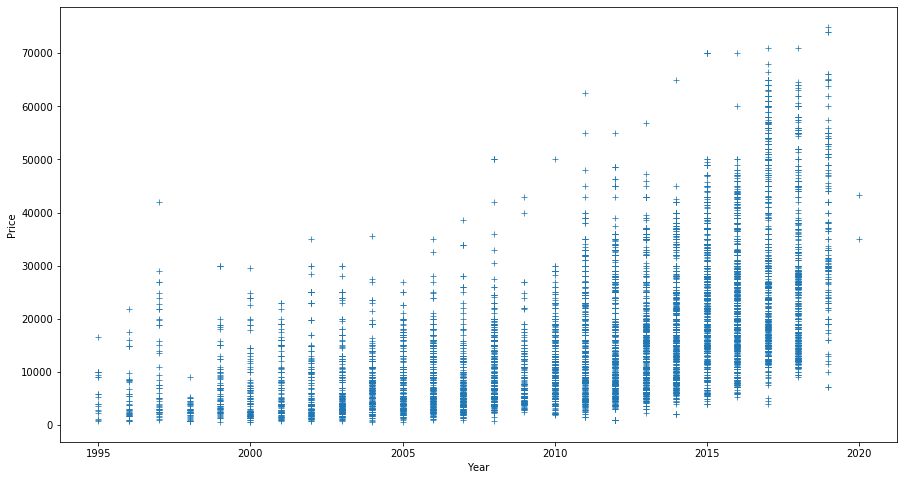

In [25]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='Year',y='Price', data=vehicle,  marker= '+')
plt.show()

In [26]:
#Fix Model names.
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'f150' : 'f-150',
                      'f250' : 'f-250', 
                      'f350' : 'f-350', 
                      'f450' : 'f-450'}
            }

vehicle.replace(model_dict, inplace=True)

#Fix Trim names.
trim_dict={'Trim': {np.nan : 'None'}}
vehicle.replace(trim_dict, inplace=True)

In [27]:
# #View any dup VINs
# pd.options.display.max_rows = 999
# vehicle.groupby(['Location','Seller','VIN']).agg({'VIN': 'count'}).nlargest(600,'VIN')

In [28]:
#Drop Odometer=0.
odZeroFilt = (vehicle['Odometer'] == 0)
drop_indices = vehicle[odZeroFilt].index
print(f'#### Drop {len(drop_indices)} Odometer is zero miles:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

# #Drop duplicate VINs.  60% of VINs are duplicates!
print('\n#### Duplicate VINs dropped:', vehicle.duplicated(subset=['VIN'], keep='first').sum())
vehicle.drop_duplicates(subset=['VIN'], inplace=True)

# #Drop vehicles with duplicate Title/Odometer/Price.
print('\n#### Duplicate Vehicles dropped:', vehicle.duplicated(subset=['Title', 'Odometer', 'Price'], keep='first').sum())
vehicle.drop_duplicates(subset=['Title', 'Odometer', 'Price'], inplace=True)

#### Drop 16 Odometer is zero miles: Int64Index([   6,    9,   10,  178,  573, 1338, 1414, 1415, 1449, 1450, 2189,
            5072, 6073, 7020, 8619, 8655],
           dtype='int64')

#### Duplicate VINs dropped: 1331

#### Duplicate Vehicles dropped: 620


In [29]:
len(vehicle)

6065

In [30]:
#Flag outliers at designated year.
def flag_outliers(df, filt_col, filt_col_val, col_to_flag):
    ''' Flag anomolies for target col_to_flag and filt_col_val.'''
    filtSer=df.loc[df[filt_col] == filt_col_val, col_to_flag].copy()
    three_std = 3 * filtSer.std()
    avg = filtSer.mean()
    lower_lim = avg - three_std
    upper_lim = avg + three_std
    print(' average:', round(avg,1), '\n', 'lower_lim:', round(lower_lim,1), '\n', 'upper_lim:', round(upper_lim,1))
    
    outside_lim=[]
    for idx in filtSer.index:      
        price = filtSer.loc[idx]        
        if price > upper_lim or price < lower_lim:
            outside_lim.append([idx, col_to_flag, price])     
    return outside_lim

outs_lim = flag_outliers(df=vehicle, filt_col='Year', filt_col_val=2014, col_to_flag='Price')        
display(outs_lim)

 average: 17370.4 
 lower_lim: -9881.4 
 upper_lim: 44622.3


[[258, 'Price', 65000.0], [8377, 'Price', 45000.0]]

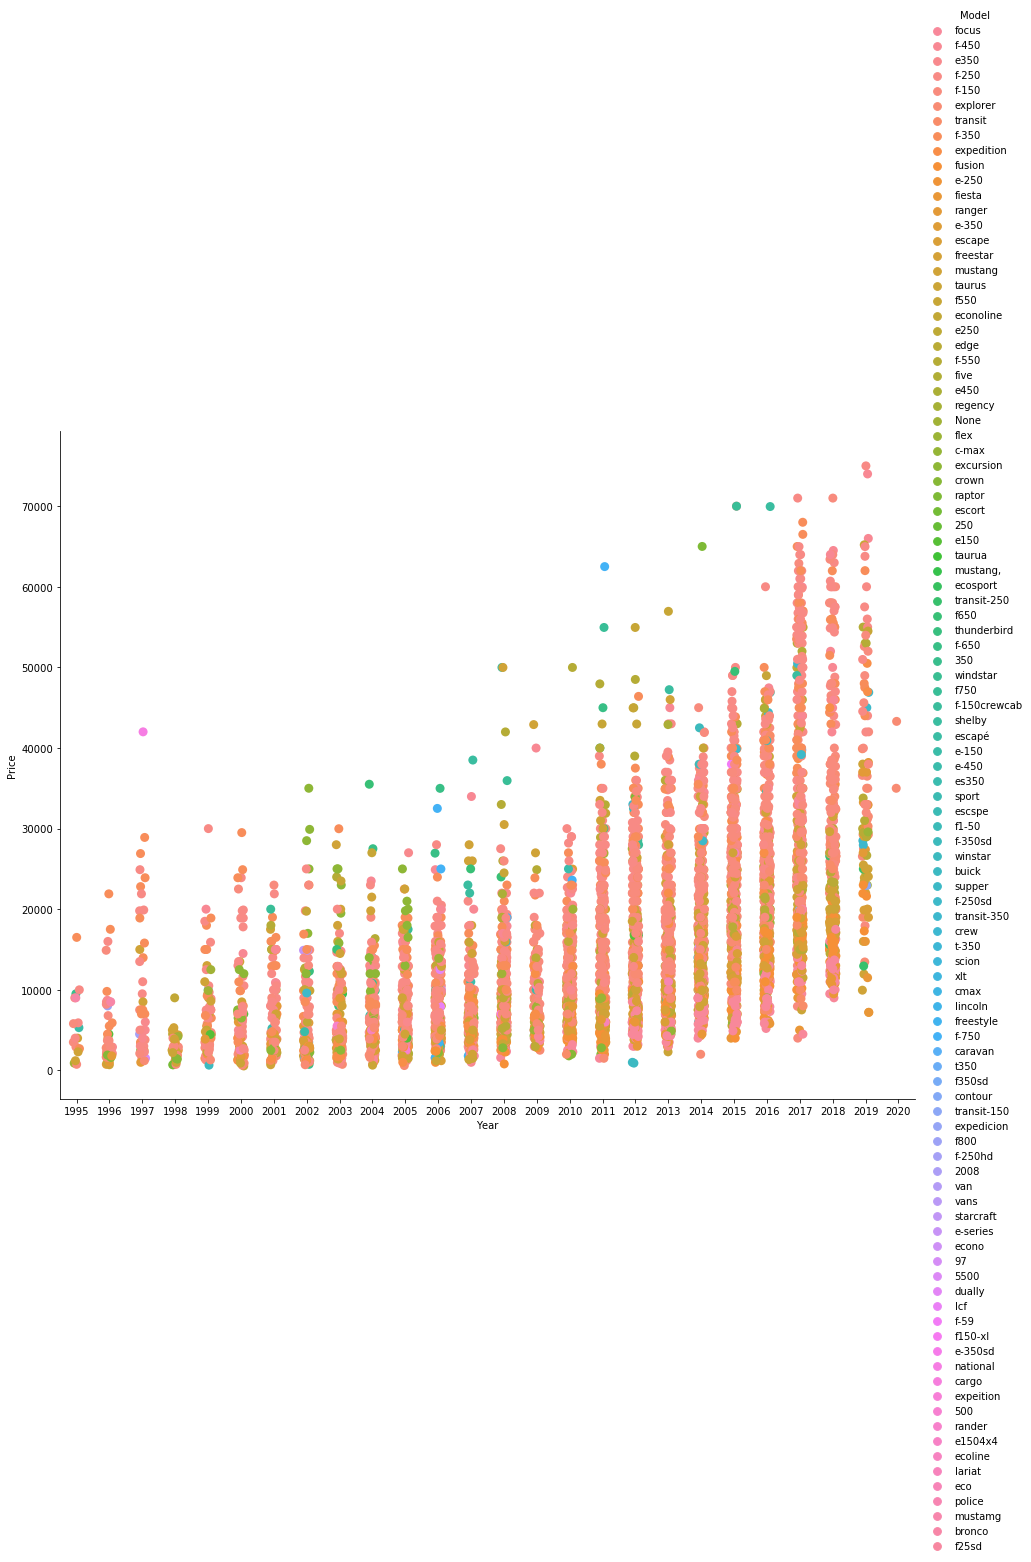

In [31]:
# #Catplot by Year, Price, and Model
sns.catplot(x='Year',y='Price',hue='Model', data=vehicle, height=10, aspect=1.3, s=9)  #s changes marker size
plt.show()

In [32]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate,DownFlag
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,owner,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se,None
2,https://austin.craigslist.org/cto/d/marble-fal...,‘04 FORD F450 SERVICE TRUCK,austin,2004,NaN,100000.0,2004 ford f450,ford,f-450,service,owner,8950.0,(Marble Falls),"\n ,\nThis is a really nice dependable ...","{'0': '<span><b>2004 FORD F450</b></span>', '1...",{'0': 'https://images.craigslist.org/01717_30H...,7022347414,None3,service,None


In [33]:
#Engineer category features Part 1.  Get feature pairs.

cat_feat=['Model', 'Trim', 'Seller']
pairs = list(itertools.combinations(cat_feat,2))
for tup in pairs:
    print(tup)
    vehicle[tup[0] + '_' + tup[1]] = vehicle[tup[0]] + '_' + vehicle[tup[1]]

('Model', 'Trim')
('Model', 'Seller')
('Trim', 'Seller')


### Drop missing and rare Models and Trims (Lowers Dimensionality)

In [34]:
#Remove vehicle 'Model' is None.
filt = (vehicle['Model'] == 'None')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} Models that are "None":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

#Remove vehicle 'Trim' is None.
filt2 = (vehicle['Trim'] == 'None')
drop_indices2 = vehicle[filt2].index
print(f'Drop {len(drop_indices2)} Trims that are "None":', drop_indices2)
vehicle = vehicle.drop(index = drop_indices2, errors = 'ignore')

Drop 24 Models that are "None": Int64Index([  151,   211,   805,  1023,  1614,  2567,  3182,  3373,  3586,
             4606,  5385,  5783,  6031,  7346,  7925,  8006,  8244,  9032,
             9505,  9705,  9863,  9882, 10091, 10237],
           dtype='int64')
Drop 507 Trims that are "None": Int64Index([   19,    29,    52,    73,    74,    90,   135,   138,   139,
              148,
            ...
            10075, 10102, 10207, 10288, 10349, 10382, 10398, 10463, 10516,
            10531],
           dtype='int64', length=507)


In [35]:
#Remove vehicle 'Model_Trim' counts under threshold.
thresh=30
trim_counts=vehicle['Model_Trim'].value_counts()             
print(f'\nDropping trim with less than {thresh} examples:\n', list(trim_counts[trim_counts < thresh].index))
trim_over_thresh = trim_counts[trim_counts >= thresh].index  #get thresh+ Model_Trim names
vehicle= vehicle[vehicle['Model_Trim'].isin(trim_over_thresh)] #boolean filter for the thresh+ Model_Trim names
print(f'\nOver {thresh} threshold trims:\n', vehicle['Model_Trim'].value_counts())


Dropping trim with less than 30 examples:
 ['taurus_sel', 'edge_sel', 'f-250_4x4', 'expedition_el', 'f-150_crew', 'f-150_raptor', 'focus_titanium', 'f-450_super', 'fusion_hybrid', 'f-250_xl', 'f-350_diesel', 'f-350_lariat', 'explorer_eddie', 'escape_xlt', 'ranger_xlt', 'f-150_stx', 'f-250_crew', 'focus_sel', 'taurus_se', 'f-350_crew', 'mustang_premium', 'f-350_4x4', 'escape_fwd', 'f-150_tx', 'focus_st', 'escape_s', 'fusion_sel', 'edge_limited', 'escape_limited', 'f-350_dually', 'excursion_limited', 'e350_box', 'f-250_sd', 'fusion_energi', 'f550_4x4', 'mustang_shelby', 'f-150_harley', 'f-250_platinum', 'econoline_cargo', 'e250_cargo', 'expedition_king', 'taurus_limited', 'f-350_xl', 'f-550_f550', 'escape_xls', 'five_hundred', 'f-150_super cab', 'f-350_f350', 'escape_sel', 'explorer_fwd', 'f-350_xlt', 'mustang_tx', 'transit_passenger', 'mustang_v6', 'ranger_supercab', 'f-150_extended', 'f-350_sd', 'c-max_hybrid', 'f-550_super', 'flex_sel', 'f-350_srw', 'transit_t', 'f-250_turbo', 'focus

In [36]:
print('vehicle shape:', vehicle.shape)
vehicle.head(1)

vehicle shape: (3514, 23)


,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,...,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,TrimAlternate,DownFlag,Model_Trim,Model_Seller,Trim_Seller
1,https://austin.craigslist.org/cto/d/red-rock-2...,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 ford focus se,ford,focus,se,...,"\n ,\n2006 Ford Focus in great mechanic...",{'0': '<span><b>2006 Ford Focus SE</b></span>'...,{'0': 'https://images.craigslist.org/00n0n_dXT...,7022331083,None2,se,None,focus_se,focus_owner,se_owner


## Get train and test, stratified by Model-Trim.

In [37]:
#Build train and test from vehicle.  Stratify by Model_Trim.
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=22)
for train_index, test_index in sss.split(vehicle, vehicle['Model_Trim']):
    train = vehicle.iloc[train_index]
    test = vehicle.iloc[test_index]

In [38]:
#Drop irrelenvant columns.
irrel_cols = ['URL_Vehicle', 'Title', 'Year_in_Title', 'RawMake', 'Make', 'SubLoc', 'Body', 'AttribDictionary', 
                    'ImageDictionary', 'VehicleID', 'VIN', 'TrimAlternate', 'DownFlag']

train = train.drop(irrel_cols, axis='columns', errors='ignore')
test = test.drop(irrel_cols, axis='columns', errors='ignore')

In [39]:
def impute_nan_by_categ(train_df, test_df, cat_col1, cat_col2, stat_col, stat_calc = 'median'):
    ''' Using train, get dictionary entry for each cat_col 1-2 group:
        {'group': {'stat_col': value}}.  Replace nan with train value in 
        both train and test.  This avoids data leakage.  Return  updated
        train and test dataframes.'''
    
    trn = train_df.copy()
    tst = test_df.copy()
    trnDict=trn.groupby([cat_col1, cat_col2]).agg({stat_col : stat_calc}).to_dict('index')
    trnDict_fallback=trn.groupby([cat_col1]).agg({stat_col : stat_calc}).to_dict('index')
    print(f'Made dictionary of {stat_calc} {stat_col} value by {cat_col1}-{cat_col2}. Fallback by {cat_col1}.\n')
        
    for k in trnDict.keys():  #scrub by Year-Model
        filtTrain = (trn[cat_col1] == k[0]) & (trn[cat_col2] == k[1]) & (trn[stat_col].isna())
        filtTest = (tst[cat_col1] == k[0]) & (tst[cat_col2] == k[1]) & (tst[stat_col].isna())
        val = trnDict[k][stat_col]
        fallback_val = trnDict_fallback[k[0]][stat_col]
        
        if np.isnan(val):  #if Year-Model missing, use Year fallback.
            print(f'Used {cat_col1} fallback for {cat_col1}-{cat_col2}: {k}. Train count: {len(trn.loc[filtTrain, stat_col])}. Test count: {len(tst.loc[filtTest, stat_col])}')
            trn.loc[filtTrain, stat_col] = fallback_val
            tst.loc[filtTest, stat_col] = fallback_val
        else:
            trn.loc[filtTrain, stat_col] = val
            tst.loc[filtTest, stat_col] = val            
            
    for key in trnDict_fallback.keys():    #scrub the missed Model-Year combos in test with Model-only fallback.
        filtTestCatCol1 = (tst[cat_col1] == key) & (tst[stat_col].isna())
        catCol1_val = trnDict_fallback[key][stat_col]
        tst.loc[filtTestCatCol1, stat_col] = catCol1_val
        
    return trn, tst, trnDict, trnDict_fallback

#Update NaNs with median odometer value by Model-Year.
train, test, trnDict, trnDict_fallback = impute_nan_by_categ(train_df=train, test_df=test, cat_col1='Year', cat_col2='Model', stat_col='Odometer')  

Made dictionary of median Odometer value by Year-Model. Fallback by Year.

Used Year fallback for Year-Model: (1995, 'mustang'). Train count: 2. Test count: 0
Used Year fallback for Year-Model: (1998, 'explorer'). Train count: 2. Test count: 0
Used Year fallback for Year-Model: (2000, 'explorer'). Train count: 1. Test count: 0
Used Year fallback for Year-Model: (2002, 'crown'). Train count: 1. Test count: 0
Used Year fallback for Year-Model: (2002, 'focus'). Train count: 1. Test count: 0
Used Year fallback for Year-Model: (2011, 'fiesta'). Train count: 1. Test count: 0


In [40]:
#Fix understated odometer values.
filt_under_1K = train['Odometer'] < 1000
train.loc[filt_under_1K, 'Odometer'] = train.loc[filt_under_1K, 'Odometer'] * 1000

filt_under_1K = test['Odometer'] < 1000
test.loc[filt_under_1K, 'Odometer'] = test.loc[filt_under_1K, 'Odometer'] * 1000

#Fix overstated odometer values.
filt_over_1M = train['Odometer'] > 1_000_000
train.loc[filt_over_1M, 'Odometer'] = train.loc[filt_over_1M, 'Odometer'] / 1000

filt_over_1M = test['Odometer'] > 1_000_000
test.loc[filt_over_1M, 'Odometer'] = test.loc[filt_over_1M, 'Odometer'] / 1000

In [41]:
#Engineer features Part 2.
def get_polyfeatures(train, target, numer_cols, degree=5):
    '''
    Returns top train feature correlations as DataFrame.
    '''
    from sklearn.preprocessing import PolynomialFeatures
    poly=PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)    
    ptrn = train[numer_cols].copy()
    orig_cols = set(ptrn.columns.values)
    ptrn=pd.DataFrame(data=poly.fit_transform(ptrn),index=train.index,columns=poly.get_feature_names(input_features=numer_cols))
    final_cols = set(ptrn.columns.values)
    added_cols = final_cols - orig_cols
    print('Poly columns:', added_cols, '\n')
            
    #Get top correlation dataframe and top features list. 
    corrList = [[c, np.corrcoef(ptrn[c].values, train[target].values)[1,0]] for c in ptrn.columns]
    corrtrn=pd.DataFrame(data=corrList, columns=['feature','PriceCorr']).sort_values(by='PriceCorr', ascending=False).dropna().reset_index(drop=True)
    print('train correlations:\n\n', corrtrn)
    return ptrn[added_cols]  

num_feat=[col for col in train.select_dtypes(exclude='object').columns];
num_feat.remove('Price');

#Get poly feature dataframe.
p_added = get_polyfeatures(train=train, target='Price', numer_cols=num_feat, degree=2)

#Add certain poly features to train and test
train['Year^2'] = train['Year']**2
train['Year_Odometer'] = train['Year'] * train['Odometer']

test['Year^2'] = test['Year']**2
test['Year_Odometer'] = test['Year'] * test['Odometer']

Poly columns: {'Odometer^2', 'Year Odometer', 'Year^2'} 

train correlations:

          feature  PriceCorr
0         Year^2   0.587005
1           Year   0.586726
2     Odometer^2  -0.248602
3  Year Odometer  -0.409683
4       Odometer  -0.410989


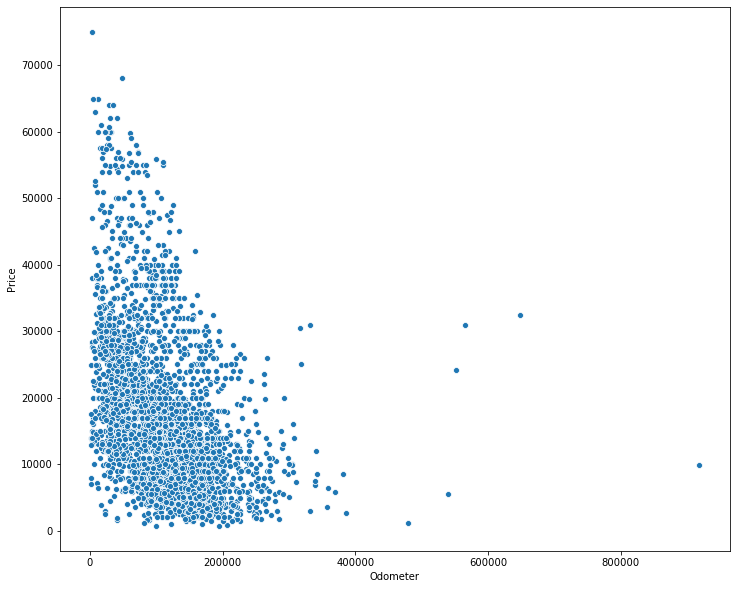

In [42]:
plt.figure(figsize=(12,10))
sns.scatterplot(x='Odometer', y='Price', data=train)
plt.show()

In [43]:
#Create numeric version of train for pairplotting.
train2=train.copy()
print(train2.dtypes)
display(train2.head(2))

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

for col in train2.select_dtypes('object').columns.values:  #Encode categoricals as ordinal
    train2[col] = le.fit_transform(train2[col].tolist())
display(train2.head(3))

Location          object
Year               int64
Odometer         float64
Model             object
Trim              object
Seller            object
Price            float64
Model_Trim        object
Model_Seller      object
Trim_Seller       object
Year^2             int64
Year_Odometer    float64
dtype: object


,Location,Year,Odometer,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer
4641,elpaso,2015,141322.0,f-250,xlt,dealer,15995.0,f-250_xlt,f-250_dealer,xlt_dealer,4060225,284763830.0
80,austin,2015,171800.0,f-250,super duty,dealer,29997.0,f-250_super duty,f-250_dealer,super duty_dealer,4060225,346177000.0


,Location,Year,Odometer,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer
4641,2,2015,141322.0,6,25,0,15995.0,26,12,50,4060225,284763830.0
80,0,2015,171800.0,6,19,0,29997.0,25,12,36,4060225,346177000.0
7475,3,2007,104477.0,11,11,0,6399.0,36,22,22,4028049,209685339.0


In [44]:
#Investigate outliers revealed in pairplot.
# sns.set(font_scale=1.5)
# sns.pairplot(train2)
# plt.show()

In [45]:
#Get numeric train correlations
train2.corr()['Price'].sort_values(ascending=False)

Price            1.000000
Year^2           0.587005
Year             0.586726
Trim             0.102287
Trim_Seller      0.088382
Model_Trim       0.056026
Location         0.035680
Model           -0.050372
Model_Seller    -0.073757
Seller          -0.302538
Year_Odometer   -0.409683
Odometer        -0.410989
Name: Price, dtype: float64

## Add knn_price base feature

In [46]:
#Helper functions

def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

def scale_num_df(train_df, test_df, numer_cols, scaler):
    '''Scale train.  Transform test with the same scaling stats.
    Returns scaled train and scaled test.'''
    from sklearn.preprocessing import RobustScaler
    scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
    scaled_trn_num_df.index=train_df.index
    scaled_trn_num_df.columns=train_df[numer_cols].columns
    
    scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
    scaled_tst_num_df.index=test_df.index
    scaled_tst_num_df.columns=test_df[numer_cols].columns
    return scaled_trn_num_df, scaled_tst_num_df

def score_algo(model, X, y, prediction):
    from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('RMSE:', round(np.sqrt(mean_squared_error(y, prediction)), 1))
    print(' R^2:', round(r2_score(y, prediction), 4))
    print(' MAE:', round(mean_absolute_error(y, prediction),1))
#**************************************************************************    

#KNN -- Split out X and Y.
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

#Get One-Hot columns for the specified categ_columns.
categ_cols= trainX.select_dtypes('object').columns.values
ohe_train_df, ohe_test_df = one_hot_encode(train_df=trainX.copy(), test_df=testX.copy(), cat_cols=categ_cols)

#Drop original category columns.  Concatenate the One-Hot columns.
trainX = trainX.drop(columns=categ_cols, axis='columns', errors='ignore')
testX = testX.drop(columns=categ_cols, axis='columns', errors='ignore')

trainX = pd.concat([trainX, ohe_train_df], axis='columns')
testX = pd.concat([testX, ohe_test_df], axis='columns')

trainX = trainX.drop(columns=['Make_ford'], axis='columns', errors='ignore')
testX = testX.drop(columns=['Make_ford'], axis='columns', errors='ignore')

#Rescale
trainXS, testXS = scale_num_df(trainX.copy(), testX.copy(), trainX.columns, RobustScaler())

#Instantiate KNN
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=10)

#knn fit.  predict both train and test.
knn.fit(trainXS, trainY)

trn_pred=knn.predict(trainXS)
tst_pred=knn.predict(testXS)

#Score
score_algo(knn, trainXS, trainY, trn_pred)
score_algo(knn, testXS, testY, tst_pred)

-----------------------------------------------
##### KNeighborsRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 4444.7
 R^2: 0.8501
 MAE: 3036.3
-----------------------------------------------
##### KNeighborsRegressor - Prediction Scores:
-----------------------------------------------
RMSE: 4703.5
 R^2: 0.8087
 MAE: 3194.0


In [47]:
#Add knn_price base learner feature to train and test.
train.loc[:, 'knn_price'] = trn_pred
test.loc[:, 'knn_price'] = tst_pred

display('train:', train.head(2))
display('test:', test.head(2))

'train:'

,Location,Year,Odometer,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,knn_price
4641,elpaso,2015,141322.0,f-250,xlt,dealer,15995.0,f-250_xlt,f-250_dealer,xlt_dealer,4060225,284763830.0,24282.0
80,austin,2015,171800.0,f-250,super duty,dealer,29997.0,f-250_super duty,f-250_dealer,super duty_dealer,4060225,346177000.0,26884.5


'test:'

,Location,Year,Odometer,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,knn_price
1652,dallas,2003,167254.0,f-250,lariat,dealer,16995.0,f-250_lariat,f-250_dealer,lariat_dealer,4012009,335009762.0,12635.4
1854,dallas,2005,157238.0,f-250,super duty,dealer,15995.0,f-250_super duty,f-250_dealer,super duty_dealer,4020025,315262190.0,13431.4


### Save Preprocessed data - train and test

In [48]:
#Save tables to PostgreSQL database.

import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

#Write vehicle table with json
vehicle.to_sql(name='vehicle', con=engine, if_exists='replace', index=True,\
               dtype={'AttribDictionary': JSONB, 'ImageDictionary': JSONB})

#Write train and test
train.to_sql(name='trainClean', con=engine, if_exists='replace', index=True)
test.to_sql(name='testClean', con=engine, if_exists='replace', index=True)

In [49]:
print('train shape:', train.shape, '| test shape:', test.shape)

train shape: (3162, 13) | test shape: (352, 13)


In [50]:
train.head()

,Location,Year,Odometer,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,knn_price
4641,elpaso,2015,141322.0,f-250,xlt,dealer,15995.0,f-250_xlt,f-250_dealer,xlt_dealer,4060225,284763830.0,24282.0
80,austin,2015,171800.0,f-250,super duty,dealer,29997.0,f-250_super duty,f-250_dealer,super duty_dealer,4060225,346177000.0,26884.5
7475,houston,2007,104477.0,mustang,gt,dealer,6399.0,mustang_gt,mustang_dealer,gt_dealer,4028049,209685339.0,9912.4
3346,dallas,2010,107229.5,explorer,sport,owner,18969.0,explorer_sport,explorer_owner,sport_owner,4040100,215531295.0,7546.4
5499,houston,2016,84490.0,transit,cargo,dealer,17995.0,transit_cargo,transit_dealer,cargo_dealer,4064256,170331840.0,17666.9
